대형 폐기물 분류 모델
=============

### 데이터 불러오기

In [1]:

# 폴더 경로 기반으로 재설정한 초기함수

def trash_init(label_filter, resolution):
    base_dir = 'C:\\Users\\park\\Desktop\\model_1\\hackathon - 복사본\\'
    images = []
    idx = []

    for label in label_filter:
        img_dir = base_dir + label +'/'
        img_list = os.listdir(img_dir)
        print(f'processing {img_dir} folder')

        for img_name in img_list:
            
            imagepath = os.path.join(img_dir, img_name)
            try:
                img = Image.open(imagepath)
            except FileNotFoundError:
                print('FileNotFoundError / continued')
                continue
            except UnidentifiedImageError:
                continue

            img_resized = img.resize(resolution)
            pixels = np.array(img_resized)
            images.append(pixels)


            label_idx = label_filter.index(label)
            idx.append(np.eye(10)[label_idx])

    X = np.asarray(images, dtype=np.float32)
    y = np.asarray(idx)
    
    return X, y

In [2]:
import os
import numpy as np
from PIL import Image
from PIL import UnidentifiedImageError
label_filter = ['침대', '밥상', '서랍장', '수납장', '의자', '선풍기' ,'냉장고', '장롱', '책상', '소파']


# 데이터 리사이징
X, y = trash_init(label_filter, [112,112])   

processing C:\Users\park\Desktop\model_1\hackathon - 복사본\침대/ folder
processing C:\Users\park\Desktop\model_1\hackathon - 복사본\밥상/ folder
processing C:\Users\park\Desktop\model_1\hackathon - 복사본\서랍장/ folder
processing C:\Users\park\Desktop\model_1\hackathon - 복사본\수납장/ folder
processing C:\Users\park\Desktop\model_1\hackathon - 복사본\의자/ folder
processing C:\Users\park\Desktop\model_1\hackathon - 복사본\선풍기/ folder
processing C:\Users\park\Desktop\model_1\hackathon - 복사본\냉장고/ folder
processing C:\Users\park\Desktop\model_1\hackathon - 복사본\장롱/ folder
processing C:\Users\park\Desktop\model_1\hackathon - 복사본\책상/ folder
processing C:\Users\park\Desktop\model_1\hackathon - 복사본\소파/ folder


### 정규화

In [3]:
np.shape(X), np.shape(y)
X_norm = X/ 255.0
X_norm.max(), X_norm.min()

(1.0, 0.0)

### train_set, test_set 분리

In [4]:
# 데이터를 섞고 분할
# 약 
shuffle_map = np.arange(X_norm.shape[0])
np.random.shuffle(shuffle_map)

train_ratio = 0.95
test_ratio = 0.95

t_idx = int(X_norm.shape[0] * train_ratio)
b_idx = int(X_norm.shape[0] * test_ratio)

train_x = X_norm[shuffle_map[:t_idx]] 
train_y = y[shuffle_map[:t_idx]]

test_x  = X_norm[shuffle_map[b_idx:]] 
test_y  = y[shuffle_map[b_idx : ]]

print("train_x.shape : ", train_x.shape)
print("train_y.shape : ", train_y.shape)

print("test_x.shape : ", test_x.shape)
print("test_y.shape : ", test_y.shape)

train_x.shape :  (15905, 112, 112, 3)
train_y.shape :  (15905, 10)
test_x.shape :  (838, 112, 112, 3)
test_y.shape :  (838, 10)


### CNN 모델 설계

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='same',
                input_shape=(112,112,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size=(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


# 학습 조기종료 설정
# 모델 저장 경로 설정
callback_list = [
        tf.keras.callbacks.EarlyStopping( 
        monitor='val_accuracy', 
        patience=10      
    ),
        tf.keras.callbacks.ModelCheckpoint( 
        filepath='saved_model/keras_final', 
        monitor='val_loss',  
        save_best_only=True
    )
]



model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 256)       2

### 학습시작

In [6]:
history = model.fit(
    train_x, train_y,
    epochs=100,
    callbacks=callback_list,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/100
199/199 [==============================] - 20s 50ms/step - loss: 2.2497 - accuracy: 0.1887 - val_loss: 2.0462 - val_accuracy: 0.3090
INFO:tensorflow:Assets written to: saved_model\keras_final\assets
Epoch 2/100
199/199 [==============================] - 8s 41ms/step - loss: 1.9665 - accuracy: 0.2917 - val_loss: 1.8843 - val_accuracy: 0.2999
INFO:tensorflow:Assets written to: saved_model\keras_final\assets
Epoch 3/100
199/199 [==============================] - 8s 41ms/step - loss: 1.8141 - accuracy: 0.3438 - val_loss: 1.7221 - val_accuracy: 0.3816
INFO:tensorflow:Assets written to: saved_model\keras_final\assets
Epoch 4/100
199/199 [==============================] - 8s 41ms/step - loss: 1.6849 - accuracy: 0.3905 - val_loss: 1.6939 - val_accuracy: 0.3779
INFO:tensorflow:Assets written to: saved_model\keras_final\assets
Epoch 5/100
199/199 [==============================] - 8s 41ms/step - loss: 1.6230 - accuracy: 0.4129 - val_loss: 1.6081 - val_accuracy: 0.4241
INFO:tensorflow

INFO:tensorflow:Assets written to: saved_model\keras_final\assets
Epoch 49/100
199/199 [==============================] - 8s 41ms/step - loss: 0.7886 - accuracy: 0.7131 - val_loss: 1.1017 - val_accuracy: 0.6171
Epoch 50/100
199/199 [==============================] - 8s 41ms/step - loss: 0.7916 - accuracy: 0.7164 - val_loss: 1.0878 - val_accuracy: 0.6221
Epoch 51/100
199/199 [==============================] - 9s 43ms/step - loss: 0.7657 - accuracy: 0.7202 - val_loss: 1.0700 - val_accuracy: 0.6250
Epoch 52/100
199/199 [==============================] - 9s 44ms/step - loss: 0.7459 - accuracy: 0.7304 - val_loss: 1.1410 - val_accuracy: 0.6042
Epoch 53/100
199/199 [==============================] - 9s 44ms/step - loss: 0.7541 - accuracy: 0.7267 - val_loss: 1.2163 - val_accuracy: 0.5737
Epoch 54/100
199/199 [==============================] - 9s 43ms/step - loss: 0.7410 - accuracy: 0.7323 - val_loss: 1.1175 - val_accuracy: 0.6026
Epoch 55/100
199/199 [==============================] - 8s 42ms/

### 학습결과 시각화

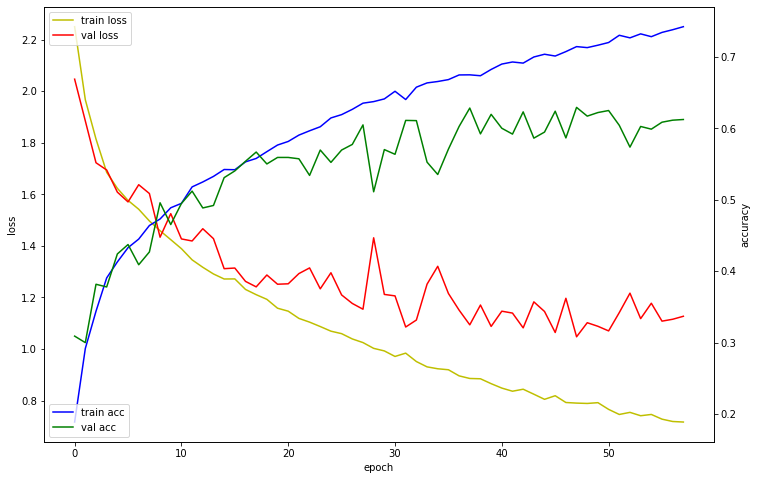

In [7]:
import matplotlib.pyplot as plt 

figs, loss_ax = plt.subplots()
acc_ax=loss_ax.twinx()
loss_ax.plot(history.history['loss'],'y',label='train loss')
loss_ax.plot(history.history['val_loss'],'r',label='val loss')

acc_ax.plot(history.history['accuracy'],'b',label='train acc')
acc_ax.plot(history.history['val_accuracy'],'g',label='val acc')

acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

figs.set_size_inches(12, 8, forward=True)
plt.show()

### test_set 모델 적용

In [8]:
res=model.evaluate(test_x, test_y, batch_size=32)
print("cost:"+str(res[0]))
print("accuracy:"+str(res[1]))

27/27 [==============================] - 1s 12ms/step - loss: 1.1143 - accuracy: 0.6253
cost:1.1143336296081543
accuracy:0.6252983212471008


### 실제 이미지 모델 적용

In [9]:
label_filter = ['침대', '밥상', '서랍장', '수납장', '의자', '선풍기' ,'냉장고', '장롱', '책상', '소파']

def trash_pred(img):
    images = []
    img_resized = img.resize([112,112])
    pixels = np.array(img_resized)
    images.append(pixels)
    X = np.asarray(images, dtype=np.float32)
    xhat = X/ 255.0
    yhat = model.predict(xhat)
    return label_filter[np.argmax(yhat)]

In [10]:
path = 'C:\\Users\\park\\Downloads\\선풍기2.jpg'

img = Image.open(path)

trash_pred(img)

'선풍기'

### 모델 저장

In [11]:
model.save('keras_final.h5')